This notebook walks through the analysis of book data and creates some of the figures.

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #https://towardsdatascience.com/how-to-perform-exploratory-data-analysis-with-seaborn-97e3413e841d
from matplotlib import cm

import itertools
from itertools import combinations
import scipy
from scipy import stats
from scipy.stats import chi2_contingency

## Skip to analysis section if the raw dataset has already been processed


## From excel, save the csv to utf-8 then import, make sure col headings are good too

In [2]:
df = pd.read_csv('bookData.csv')
# check the data frame info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   cataloger         1013 non-null   object
 1   bookid            1013 non-null   object
 2   count             1013 non-null   int64 
 3   title             1013 non-null   object
 4   author            997 non-null    object
 5   combinedName      980 non-null    object
 6   authorOfColor     1013 non-null   int64 
 7   nonPersonAuthor   1013 non-null   int64 
 8   yrpub             1013 non-null   object
 9   neighborhood      1013 non-null   object
 10  collection        1013 non-null   object
 11  age               1013 non-null   object
 12  type              1013 non-null   object
 13  category1         1013 non-null   object
 14  category1Code     1003 non-null   object
 15  category2         1013 non-null   object
 16  publication       989 non-null    object
 17  media         

In [3]:
#Convert Date to Number after removing the question marks (making them NaN)
df['yrpub'] = df['yrpub'].replace('?',None)
df['yrpub']=df['yrpub'].astype(int)
df.yrpub.unique()

array([2006, 1992, 1999, 2014, 2017, 2016, 2005, 1960, 2003, 1983, 2009,
       2010, 1997, 2002, 1996, 1998, 1985, 1994, 1980, 2015, 2013, 1990,
       2008, 1982, 1962, 1993, 2000, 2001, 2012, 1987, 2011, 2019, 2018,
       1986, 1937, 2007, 2004, 1976, 1974, 1977, 1984, 1991, 1979, 1971,
       1988, 1946, 1995, 1975, 1989, 1981, 1965, 1961, 1967, 1970, 1978,
       1969, 1950, 1964, 1963, 1954, 1949, 1928, 1966, 1958, 1968, 1959,
       1972, 1973])

###  Group the categorical and numeric columns

In [4]:
numerical = [
  'yrpub','count','authorOfColor','nonPersonAuthor'
]
categorical = [
  'neighborhood','collection','type','age','category1','category2','category1Code','languages','originalLang'
]

bks = df[numerical + categorical]
bks.shape

(1013, 13)

In [5]:
bks['collection'].head()

0    CentralDistrict6
1           Montlake4
2      Phinney-Green4
3           Montlake4
4          Northgate5
Name: collection, dtype: object

In [6]:
bks.yrpub.max()

2019

(1900.0, 2020.0)

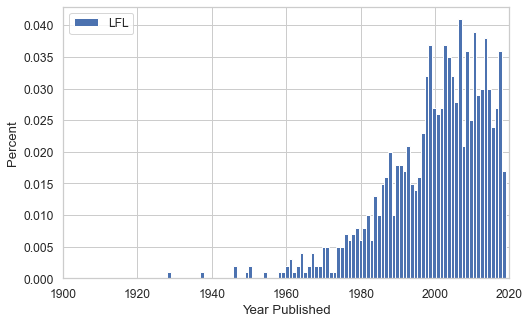

In [7]:
#'Density' Histogram of year published using mtlabplot
#yrhist = bks['yrpub'].plot.hist(bins=50)
#Same thing using seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    bks['yrpub'], norm_hist=True, kde=False, bins=92, hist_kws={"alpha": 1}
).set(xlabel='Year Published', ylabel='Percent')

plt.legend(labels=['LFL'])
#plt.legend('ABCDEF', ncol=2, loc='upper left')

plt.xlim(1900, 2020)

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Year Published')]

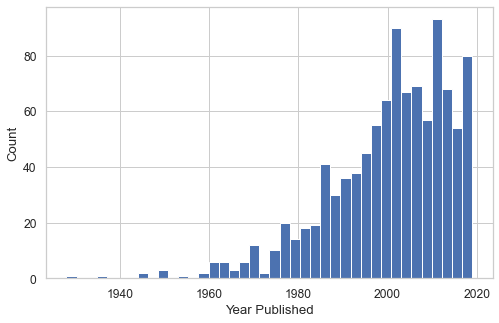

In [8]:
#Histogram of year published using mtlabplot
#yrhist = bks['yrpub'].plot.hist(bins=50)
#Same thing using seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
sns.distplot(
    bks['yrpub'], norm_hist=False, kde=False, bins=40, hist_kws={"alpha": 1}).set(xlabel='Year Published', ylabel='Count')


In [9]:
#export csv for use with SPL data in Get-SPL-data-by-hood ipynb file: 
bks.to_csv('LFL-books-years.csv', mode = 'w', index=False)

### If you are running the entire analysis for the first time, switch to the Get-SPL-data-by-hood Jupyter notebook in the publicLibraryComparison folder.
That creates several csv files need to make charts below. Specifically the percent fiction and percent juvenile charts.

# Start Analysis

In [2]:
#Skip if you are running the whole script from the start 
#Open LFL cleaned above data and the stat dataset.  These are combined in various ways below.

bks = pd.read_csv('LFL-books-years.csv',encoding='utf-8')
bksctstat = pd.read_csv('bkstats.csv',encoding='utf-8')
dfstats = pd.read_csv('lfl-stats.csv')
bks.head()

,yrpub,count,authorOfColor,nonPersonAuthor,neighborhood,collection,type,age,category1,category2,category1Code,languages,originalLang
0,1975,1,0,1,Central District,CentralDistrict2,Fiction,Adult,Anthology/Essays/Short stories,Null,AN,English,NaN
1,2012,1,0,1,Central District,CentralDistrict5,Fiction,Adult,Anthology/Essays/Short stories,Null,AN,NaN,NaN
2,2019,1,0,0,Columbia City,ColumbiaCity3,Nonfiction,Adult,Anthology/Essays/Short stories,Null,AN,English,English
3,2005,1,0,0,Phinney-Greenwood,Phinney-Green4,Fiction,Young Adult,Anthology/Essays/Short stories,Null,AN,English,English
4,1990,1,0,0,Central District,CentralDistrict2,Fiction,Adult,Anthology/Essays/Short stories,Null,AN,English,NaN


## Fiction by neighborhood


In [4]:
#Set up the Dataframe

#Groups count by Neighborhood, collection, and type (fiction or non fiction), calculate percent
bksfiction = bks.groupby(['neighborhood','collection', 'type'])['count'].sum().reset_index()
bksfiction['total'] = bksfiction.groupby('collection')['count'].transform('sum')
bksfiction['percent'] = bksfiction['count']/bksfiction['total']


#Select fiction
fic = bksfiction.loc[bksfiction['type']=='Fiction'].copy() #adding the .copy() gets rid of the settingwithcopywarning

#Sort and reindex so that the chart goes low to high
fic['median'] = fic.groupby('neighborhood')['percent'].transform('median')
fic = fic.sort_values(by=['median'], ascending=True).reset_index()


In [5]:
#Set up table for Chi Square to compare fiction proportion between neighborhoods
fichood = fic.groupby('neighborhood').agg({'count':'sum', 'total': 'sum'}).reset_index()
fichood.head()
ficTotal = fichood['count'].sum()
totBks = fichood['total'].sum()
fichood['expCount']= (ficTotal*fichood['total'])/totBks #Only need if using chisquare, not chi2: expected value is row total times col total divided by grand total. Accounts for different number of books
fichood['nonficCount']= fichood['total'] - fichood['count']
fichood.head()

,neighborhood,count,total,expCount,nonficCount
0,Central District,59,93,62.430983,34
1,Columbia City,51,79,53.032771,28
2,Laurelhurst,63,91,61.088381,28
3,Montlake,34,81,54.375372,47
4,Northgate,145,241,161.783515,96


In [6]:
#Open SPL fiction dataframe from the Get-SPL-Book-Data-by-hood jupyter file
ficSPL = pd.read_csv('../publicLibraryComparison/SPL-fiction.csv',encoding='utf-8')
ficSPL.head(10)

,neighborhood,type,count,total,percent
0,Central District,Fiction,23003,49029,0.469171
1,Columbia City,Fiction,14870,26486,0.561429
2,Laurelhurst,Fiction,29836,50942,0.585686
3,Montlake,Fiction,7731,13001,0.594647
4,Northgate,Fiction,16174,27569,0.586673
5,Phinney-Greenwood,Fiction,22772,42934,0.530395
6,Queen Anne,Fiction,10197,18491,0.551457
7,Ravenna,Fiction,29569,51059,0.579114


In [7]:
#Get the medians from the LFL data (fic) and sort so that the points go to the right places
medians = fic[['neighborhood','median']].copy()
medians.drop_duplicates(inplace=True)
medians
ficSPLsorted = pd.merge(medians, ficSPL, on='neighborhood', how='inner')
ficSPLsorted.sort_values(by=['median'], ascending=True)
#ficSPLsorted = ficSPLsorted.fillna('1.2')
ficSPLsorted

,neighborhood,median,type,count,total,percent
0,Montlake,0.494286,Fiction,7731,13001,0.594647
1,Central District,0.616667,Fiction,23003,49029,0.469171
2,Columbia City,0.622159,Fiction,14870,26486,0.561429
3,Northgate,0.629630,Fiction,16174,27569,0.586673
4,Phinney-Greenwood,0.655172,Fiction,22772,42934,0.530395
5,Laurelhurst,0.699248,Fiction,29836,50942,0.585686
6,Queen Anne,0.807692,Fiction,10197,18491,0.551457
7,Ravenna,0.833333,Fiction,29569,51059,0.579114


In [8]:
#Use SciPy to calculate Spearman correlation for median percent fiction in LFLs and percent fiction in nearby public library branch

import scipy
from scipy import stats

#The %.3f' sets the number of decimal places
coef, p = stats.spearmanr(ficSPLsorted['median'],ficSPLsorted['percent'])
print('Spearmans correlation coefficient: %.3f' % coef,' p-value: %.3f' % p)

Spearmans correlation coefficient: -0.119  p-value: 0.779


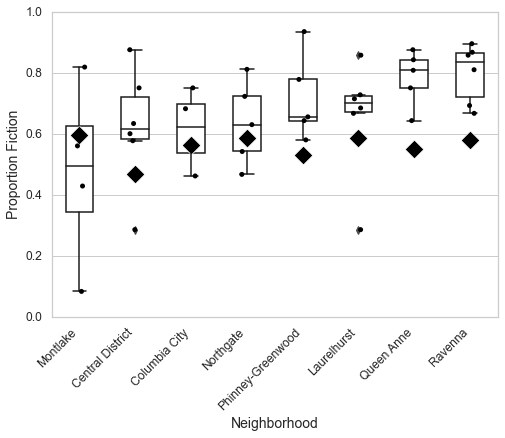

In [25]:
#Make the chart.


#Plots using Seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 8]})
bplot = sns.boxplot(y='percent', x='neighborhood', data=fic,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(y='percent', x='neighborhood', data=fic, 
                   jitter=True, 
                   marker='o', 
                   alpha=1,
                   color='black')

# SPL fiction percentages
bplot=sns.scatterplot(y='percent', x='neighborhood', data=ficSPLsorted, marker='D', color='#000000', s=175)


#Set y axis label and scale

bplot.set_ylabel("Proportion Fiction",
                fontsize=14)
bplot.set_xlabel("Neighborhood",
                fontsize=14)
bplot.set(ylim=(0, 1))

#rotate labels
for item in bplot.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right') #This sets horizontal alignment

plt.gcf().subplots_adjust(bottom=0.35) #makes room for the 'tall' x axis lables

#Save figure 
plt.savefig('../figures/fiction.eps')
    

In [26]:
#Chi Square
ficChi= fichood[['count','nonficCount']]
chi2, p, dof, ex = chi2_contingency(ficChi, correction=False) #using chi2 here rather than chisquare because including adult book rather than specifying distribution (expected values)
print("chi: ",chi2,"p-value: ",p,"degrees of freedom: ",dof)

chi:  49.887612811296755 p-value:  1.5197559839312804e-08 degrees of freedom:  7


In [18]:
# gathering all combinations for post-hoc chi2
#Thanks to: https://neuhofmo.github.io/chi-square-and-post-hoc-in-python/
all_combinations = list(combinations(ficChi.index, 2))
print("Significance results:")
for comb in all_combinations:
    # subset df into a dataframe containing only the pair "comb"
    new_df = ficChi[(ficChi.index == comb[0]) | (ficChi.index == comb[1])]
    # running chi2 test
    chi2, p, dof, ex = chi2_contingency(new_df, correction=False)
    print(f"Chi2 result for pair {comb}: {chi2}, p-value: {p}")

Significance results:
Chi2 result for pair (0, 1): 0.0230813781993328, p-value: 0.8792456420559743
Chi2 result for pair (0, 2): 0.6901351095411246, p-value: 0.4061184287559032
Chi2 result for pair (0, 3): 8.017396335454947, p-value: 0.004633012906564043
Chi2 result for pair (0, 4): 0.30273670224381605, p-value: 0.5821718192051961
Chi2 result for pair (0, 5): 2.5811154782455192, p-value: 0.10814542723726947
Chi2 result for pair (0, 6): 6.316825460630103, p-value: 0.011959755369741466
Chi2 result for pair (0, 7): 8.03180799537338, p-value: 0.00459629369788509
Chi2 result for pair (1, 2): 0.4181827499615641, p-value: 0.5178452122676749
Chi2 result for pair (1, 3): 8.18961296035839, p-value: 0.004213091101864684
Chi2 result for pair (1, 4): 0.4833265393604431, p-value: 0.4869193822300941
Chi2 result for pair (1, 5): 1.8101021657463954, p-value: 0.17849597462776196
Chi2 result for pair (1, 6): 5.120996096060569, p-value: 0.023638044364151588
Chi2 result for pair (1, 7): 6.555101139142739, p

In [20]:
#Here's the list of neighborhoods corresponding to above. Bonferonni- 0.05/29=0.00172
#Montlake is different than Phinney, Queen, Laurelhurst, and Ravenna. Northgate is different than Queen Anne and Ravenna.
fichood

,neighborhood,count,total,expCount,nonficCount
0,Central District,59,93,62.430983,34
1,Columbia City,51,79,53.032771,28
2,Laurelhurst,63,91,61.088381,28
3,Montlake,34,81,54.375372,47
4,Northgate,145,241,161.783515,96
5,Phinney-Greenwood,139,191,128.218471,52
6,Queen Anne,85,107,71.829196,22
7,Ravenna,100,124,83.241311,24


## Age by Neighborhood

In [27]:
bks.age.unique()

array(['Adult', 'Young Adult', 'Childrens'], dtype=object)

Text(0, 0.5, 'Number of books')

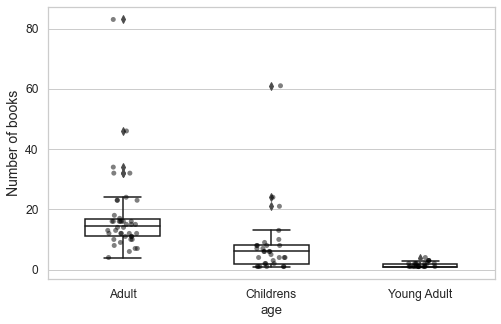

In [28]:
#Groups count by collection and age
bksage = bks.groupby(['neighborhood', 'collection','age'])['count'].sum().reset_index()
#bksage.head()

#Plots using Seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})
bplot = sns.boxplot(y='count', x='age', data=bksage,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(y='count', x='age', data=bksage, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

bplot.set_ylabel("Number of books",
                fontsize=14)

### Juvenile books across neighborhoods
Appears SPL includes teen books in juvenile

In [29]:
#Set up the Dataframe for box and whisker

#Groups count by Neighborhood, collection, and type. 
bksjuvenile = bks.groupby(['neighborhood','collection', 'age'])['count'].sum().reset_index()

#Get the percent juvenile by calculating percent and subracting adult percent from 1
bksjuvenile['total'] = bksjuvenile.groupby('collection')['count'].transform('sum')
bksjuvenile['typepercent'] = bksjuvenile['count']/bksjuvenile['total']
bksjuvenile = bksjuvenile[bksjuvenile.age == 'Adult'] #Select only adult rows
bksjuvenile['juvpercent'] = 1 - bksjuvenile['typepercent'] #calculate juvenile percent, this also puts zero for LFLs with only adult books
bksjuvenile = bksjuvenile.drop(['age'], axis=1) #Drop this column, not needed anymore
bksjuvenile = bksjuvenile.rename(columns={"typepercent": "adultpercent"}) #rename this column since it only shows adult percent now
bksjuvenile = bksjuvenile.rename(columns={"count": "adultcount"})

#Sort and reindex so that the chart goes low to high
juv = bksjuvenile #create a new dataframe just to use an easier name
juv['median'] = juv.groupby('neighborhood')['juvpercent'].transform('median') #For Central, median is zero since three LFLs had zero juv books

juv = juv.sort_values(by=['median'], ascending=True).reset_index()


In [30]:
d = {'adultcount': ['sum'], 'total': ['sum']}
lflJPercent = juv.groupby('neighborhood').agg(d).reset_index() #create totals table
lflJPercent.columns = ['_'.join(col) for col in lflJPercent.columns.values] # flatten MultiIndex columns
lflJPercent = lflJPercent.rename(columns={"neighborhood_": "neighborhood"})
lflJPercent = lflJPercent.rename(columns={"adultcount_sum": "adultcount"})
lflJPercent = lflJPercent.rename(columns={"total_sum": "lfltotal"})
lflJPercent['juvpercent'] = 1 - (lflJPercent['adultcount']/lflJPercent['lfltotal']) #calculate juv percent for neighborhood

In [31]:
#Open SPL fiction dataframe from the Get-SPL-Book-Data-by-hood jupyter file
juvSPL = pd.read_csv('../publicLibraryComparison/SPL-juvenilePercent.csv',encoding='utf-8')
juvSPL.head(8)

,neighborhood,ageletter,count,total,percent
0,Central District,j,20115,49029,0.410267
1,Columbia City,j,11587,26486,0.437476
2,Laurelhurst,j,23079,50942,0.453045
3,Montlake,j,6266,13006,0.481778
4,Northgate,j,11591,27569,0.420436
5,Phinney-Greenwood,j,18297,42934,0.426166
6,Queen Anne,j,7791,18491,0.421340
7,Ravenna,j,22990,51226,0.448796


In [32]:
#Get the medians from the LFL data and sort so that the points go to the right places
mediansjuv = juv[['neighborhood','median']].copy()
mediansjuv.drop_duplicates(inplace=True)
#merge with juvenile percent table
lfldata = pd.merge(lflJPercent, mediansjuv, on='neighborhood', how='inner')
#merge with SPL data
juvSPLsorted = pd.merge(lfldata, juvSPL, on='neighborhood', how='inner')
juvSPLsorted.sort_values(by=['median'], ascending=True)
#juvSPLsorted = juvSPLsorted.fillna('1.2')
juvSPLsorted.head(8)

,neighborhood,adultcount,lfltotal,juvpercent,median,ageletter,count,total,percent
0,Central District,69,93,0.258065,0.000000,j,20115,49029,0.410267
1,Columbia City,64,86,0.255814,0.076923,j,11587,26486,0.437476
2,Laurelhurst,67,91,0.263736,0.178571,j,23079,50942,0.453045
3,Montlake,74,81,0.086420,0.111429,j,6266,13006,0.481778
4,Northgate,160,241,0.336100,0.135135,j,11591,27569,0.420436
5,Phinney-Greenwood,127,191,0.335079,0.333333,j,18297,42934,0.426166
6,Queen Anne,72,107,0.327103,0.375000,j,7791,18491,0.421340
7,Ravenna,97,124,0.217742,0.252381,j,22990,51226,0.448796


In [33]:
#Use Spearman correlation to compare library percent juvenile and LFL median percent 

#The %.3f' sets the number of decimal places
coef, p = stats.spearmanr(juvSPLsorted['juvpercent'],juvSPLsorted['percent'])
print('Spearmans correlation coefficient: %.3f' % coef,' p-value: %.3f' % p)

Spearmans correlation coefficient: -0.619  p-value: 0.102


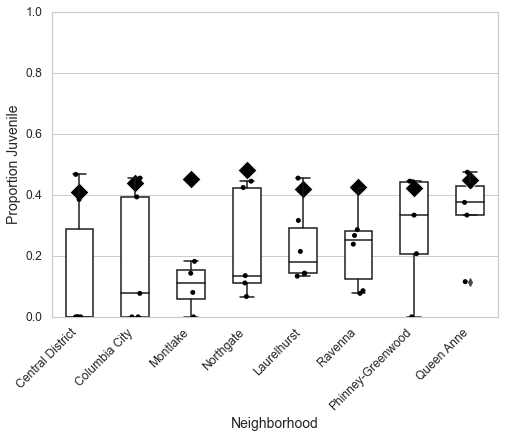

In [35]:
#Make the chart.


#Plots using Seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 8]})
bplot = sns.boxplot(y='juvpercent', x='neighborhood', data=juv,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(y='juvpercent', x='neighborhood', data=juv, 
                   jitter=True, 
                   marker='o', 
                   alpha=1,
                   color='black')

# SPL juvenile percentages
bplot=sns.scatterplot(y='percent', x='neighborhood', data=juvSPLsorted, marker='D', color='#000000', s=175)


#Set y axis label and scale

bplot.set_ylabel("Proportion Juvenile",
                fontsize=14)
bplot.set_xlabel("Neighborhood",
                fontsize=14)
bplot.set(ylim=(0, 1))



#rotate labels
for item in bplot.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right') #This sets horizontal alignment

plt.gcf().subplots_adjust(bottom=0.35) #makes room for the 'tall' x axis lables

#Save figure 
plt.savefig('../figures/age.eps')

In [29]:
juvhood = lflJPercent #use dataframe created above
juvhood['count'] =  juvhood['lfltotal'] - juvhood['adultcount']
juvhood.head()

,neighborhood,adultcount,lfltotal,juvpercent,count
0,Central District,69,93,0.258065,24
1,Columbia City,64,86,0.255814,22
2,Laurelhurst,67,91,0.263736,24
3,Montlake,74,81,0.086420,7
4,Northgate,160,241,0.336100,81


In [30]:
#Set up table for Chi Square to compare age proportion between neighborhoods
juvTotal = juvhood['count'].sum()
totBks = juvhood['lfltotal'].sum()
juvhood['expCount']= (juvTotal*juvhood['lfltotal'])/totBks #only need this if doing chisquare rather than chi2: expected value is row total times col total divided by grand total. Accounts for different number of books
juvhood.head(8)

,neighborhood,adultcount,lfltotal,juvpercent,count,expCount
0,Central District,69,93,0.258065,24,26.047337
1,Columbia City,64,86,0.255814,22,24.086785
2,Laurelhurst,67,91,0.263736,24,25.487179
3,Montlake,74,81,0.086420,7,22.686391
4,Northgate,160,241,0.336100,81,67.499014
5,Phinney-Greenwood,127,191,0.335079,64,53.495069
6,Queen Anne,72,107,0.327103,35,29.968442
7,Ravenna,97,124,0.217742,27,34.729783


In [33]:
juvChi = juvhood[['count','adultcount']]
chi2, p, dof, ex = chi2_contingency(juvChi, correction=False) #using chi2 here rather than chisquare because including adult book rather than specifying distribution (expected values)
print("chi: ",chi2,"p-value: ",p)

chi:  25.840693141658427 p-value:  0.0005377640461926799


In [34]:
# gathering all combinations for post-hoc chi2
#Thanks to: https://neuhofmo.github.io/chi-square-and-post-hoc-in-python/
all_combinations = list(combinations(juvChi.index, 2))
print("Significance results:")
for comb in all_combinations:
    # subset df into a dataframe containing only the pair "comb"
    new_df = juvChi[(juvChi.index == comb[0]) | (juvChi.index == comb[1])]
    # running chi2 test
    chi2, p, dof, ex = chi2_contingency(new_df, correction=False)
    print(f"Chi2 result for pair {comb}: {chi2}, p-value: {p}")

Significance results:
Chi2 result for pair (0, 1): 0.001185242371397054, p-value: 0.9725363749043079
Chi2 result for pair (0, 2): 0.007673540880371964, p-value: 0.930195596266824
Chi2 result for pair (0, 3): 8.711252442782097, p-value: 0.003162518600832293
Chi2 result for pair (0, 4): 1.8958383896209865, p-value: 0.1685448762760905
Chi2 result for pair (0, 5): 1.7347443253298933, p-value: 0.18780613566434542
Chi2 result for pair (0, 6): 1.1402645411126129, p-value: 0.28559643559544545
Chi2 result for pair (0, 7): 0.4805988660524445, p-value: 0.48815118007814884
Chi2 result for pair (1, 2): 0.014427386767401788, p-value: 0.9043927968773736
Chi2 result for pair (1, 3): 8.341034765419469, p-value: 0.003875951593633555
Chi2 result for pair (1, 4): 1.893449208435591, p-value: 0.16881339759186703
Chi2 result for pair (1, 5): 1.7403560228400172, p-value: 0.18709372261909404
Chi2 result for pair (1, 6): 1.1643109845775441, p-value: 0.2805732710878809
Chi2 result for pair (1, 7): 0.411461561042

While the overall chi square test is significant, even bonferroni corrected, none of the indiv. tests are suggesting the significance is an accumulation of small contributions from combinations rather than a large contribution for any one or more combinations.

In [35]:
#Here's the list of neighborhoods corresponding to above. Bonferonni- 0.05/29=0.00172
juvhood

,neighborhood,adultcount,lfltotal,juvpercent,count,expCount
0,Central District,69,93,0.258065,24,26.047337
1,Columbia City,64,86,0.255814,22,24.086785
2,Laurelhurst,67,91,0.263736,24,25.487179
3,Montlake,74,81,0.086420,7,22.686391
4,Northgate,160,241,0.336100,81,67.499014
5,Phinney-Greenwood,127,191,0.335079,64,53.495069
6,Queen Anne,72,107,0.327103,35,29.968442
7,Ravenna,97,124,0.217742,27,34.729783


## Examine Author Diversity
The list was first compared to two lists crowdsourced on GoodReads (https://www.goodreads.com/list/show/96119._ReadPOC_List_of_Books_by_Authors_of_Color and https://www.goodreads.com/list/show/96282._ReadPOC_List_of_Romance_Books_by_Authors_of_Color). We also researched every author in an attempt to record if they identify as BIPOC.

In [26]:
# Remove non person authors
bksauthors = bks.loc[bks['nonPersonAuthor']==0].copy()
bksauthors.head()

,yrpub,count,authorOfColor,nonPersonAuthor,neighborhood,collection,type,age,category1,category2,category1Code,languages,originalLang
2,2019,1,0,0,Columbia City,ColumbiaCity3,Nonfiction,Adult,Anthology/Essays/Short stories,Null,AN,English,English
3,2005,1,0,0,Phinney-Greenwood,Phinney-Green4,Fiction,Young Adult,Anthology/Essays/Short stories,Null,AN,English,English
4,1990,1,0,0,Central District,CentralDistrict2,Fiction,Adult,Anthology/Essays/Short stories,Null,AN,English,NaN
5,2004,1,0,0,Northgate,Northgate3,Fiction,Adult,Anthology/Essays/Short stories,Null,AN,English,English
6,1991,1,0,0,Montlake,Montlake5,Fiction,Adult,Anthology/Essays/Short stories,Null,AN,English,English


In [27]:
#Some basic stats
aocbooks=bksauthors['authorOfColor'].sum()
totalbks = bksauthors['count'].sum()
aocPercent = aocbooks/totalbks
print(f'Total books: {totalbks}, total authors of color: {aocbooks}, proportion authors of color: {aocPercent}')

Total books: 950, total authors of color: 74, proportion authors of color: 0.07789473684210527


In [28]:
#Percent by neighborhood 
#Groups count by neighborhood, collection, calculate percent
bksauthorshood = bksauthors.groupby(['neighborhood', 'authorOfColor'])['count'].sum().reset_index()
bksauthorshood['total'] = bksauthorshood.groupby('neighborhood')['count'].transform('sum')
bksauthorshood['percent'] = bksauthorshood['count']/bksauthorshood['total']

bksauthorshood = bksauthorshood.loc[bksauthorshood['authorOfColor']==1].copy() #adding the .copy() gets rid of the settingwithcopywarning

#Sort and reindex so that the chart goes low to high
bksauthorshood = bksauthorshood.sort_values(by=['percent'], ascending=True).reset_index()

In [29]:
bksauthorshood.head(8)

,index,neighborhood,authorOfColor,count,total,percent
0,11,Phinney-Greenwood,1,9,177,0.050847
1,7,Montlake,1,4,66,0.060606
2,5,Laurelhurst,1,6,91,0.065934
3,3,Columbia City,1,6,84,0.071429
4,15,Ravenna,1,9,124,0.072581
5,1,Central District,1,6,82,0.073171
6,13,Queen Anne,1,9,102,0.088235
7,9,Northgate,1,25,224,0.111607


In [30]:
print('Total ', bksauthorshood['total'].sum(), ' Authors of color: ', bksauthorshood['count'].sum())

Total  950  Authors of color:  74


In [32]:
#Chi Square. Problem is Central is less than 5 so cannot use.

#from scipy.stats import chisquare
#bksauthorshood['expectedAoc']=bksauthorshood['total']/991*68 #add column of expected number of author of color books
#chisquare(bksauthorshood['count'],f_exp=bksauthorshood['expectedAoc'])


Power_divergenceResult(statistic=7.553836562607475, pvalue=0.37357287603207784)

In [33]:
#Percent by LFL and neighborhood

#Groups count by neighborhood, collection, calculate percent
bksauthorsgrp = bksauthors.groupby(['neighborhood','collection', 'authorOfColor'])['count'].sum().reset_index()
bksauthorsgrp['total'] = bksauthorsgrp.groupby('collection')['count'].transform('sum')
bksauthorsgrp['percent'] = bksauthorsgrp['count']/bksauthorsgrp['total']



In [34]:
# I inspected the data and there are no LFLs with 100% authors of color.  To preserve the LFLs with no authors of color
# convert those with 100% white authors to zeros.  Then remove the rows that show percent white authors below 100%
#leaving percent column only percent authors of color

bksauthorsgrp.loc[bksauthorsgrp.percent == 1, 'percent'] = 0
bksaoc = bksauthorsgrp.drop(bksauthorsgrp[(bksauthorsgrp['authorOfColor'] == 0) & (bksauthorsgrp['percent'] > 0)].index)
bksaoc.head()

,neighborhood,collection,authorOfColor,count,total,percent
0,Central District,CentralDistrict1,0,3,3,0.000000
2,Central District,CentralDistrict2,1,2,15,0.133333
3,Central District,CentralDistrict3,0,28,28,0.000000
5,Central District,CentralDistrict4,1,1,22,0.045455
7,Central District,CentralDistrict5,1,2,6,0.333333


In [35]:
#Sort and reindex so that the chart will go low to high
bksaoc['median'] = bksaoc.groupby('neighborhood')['percent'].transform('median')
bksaoc = bksaoc.sort_values(by=['median'], ascending=True).reset_index()
bksaoc.head()

,index,neighborhood,collection,authorOfColor,count,total,percent,median
0,33,Montlake,Montlake6,0,11,11,0.000000,0.020833
1,32,Montlake,Montlake5,1,3,16,0.187500,0.020833
2,30,Montlake,Montlake4,1,1,24,0.041667,0.020833
3,28,Montlake,Montlake2,0,15,15,0.000000,0.020833
4,43,Phinney-Greenwood,Phinney-Green1,0,14,14,0.000000,0.032787


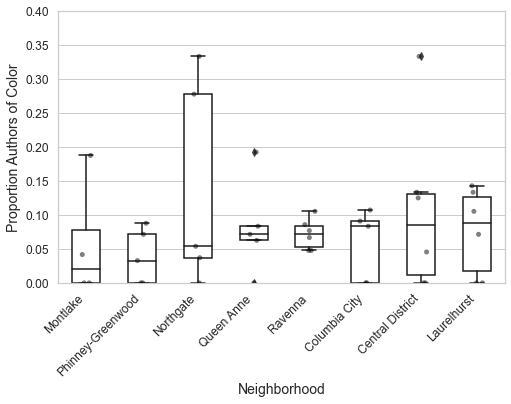

In [36]:
#Plots using Seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

bplot = sns.boxplot(y='percent', x='neighborhood', data=bksaoc,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bplot=sns.stripplot(y='percent', x='neighborhood', data=bksaoc, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

#Set y axis label and scale

bplot.set_ylabel("Proportion Authors of Color",
                fontsize=14)
bplot.set_xlabel("Neighborhood",
                fontsize=14)
bplot.set(ylim=(0, 0.4))



#rotate labels
for item in bplot.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right') #This sets horizontal alignment

### Add in socioeconomic data from census data notebook
The section this produces is a scatterplot of percent authors of color versus gini-simpson index.

In [37]:
dfsocioecon = pd.read_csv('../census/socioeconomic-by-neighborhood.csv', encoding='utf-8')

In [38]:
#Merge with the lfl number dataset
dfAocSocio = pd.merge(bksauthorshood, dfsocioecon, on='neighborhood', how='inner')
dfAocSocio.head()

,index,neighborhood,authorOfColor,count,total,percent,expectedAoc,avg-median-income,pop,numlfls,...,afam,amin,as,hw,ot,combo1,combo2,combo3,simpsons,gini-simp
0,11,Phinney-Greenwood,1,9,177,0.050847,12.145308,96876.333333,23948,20,...,424,85,1668,14,310,1469,94,1375,0.722881,0.277119
1,7,Montlake,1,4,66,0.060606,4.528759,144488.500000,8644,8,...,109,36,763,38,91,461,60,401,0.721553,0.278447
2,5,Laurelhurst,1,6,91,0.065934,6.244198,127971.500000,10479,11,...,303,0,1289,13,45,478,0,478,0.669051,0.330949
3,3,Columbia City,1,6,84,0.071429,5.763875,67992.000000,16883,9,...,5152,159,4960,86,169,1458,0,1458,0.289836,0.710164
4,15,Ravenna,1,9,124,0.072581,8.508577,101129.833333,24187,24,...,376,58,3135,98,298,1405,85,1320,0.649513,0.350487


In [39]:
#Get rid of extraneous columns
dfAocSocio = dfAocSocio.drop(columns=['tot','wh','afam','amin','as','hw','ot','combo1','combo2','combo3'])

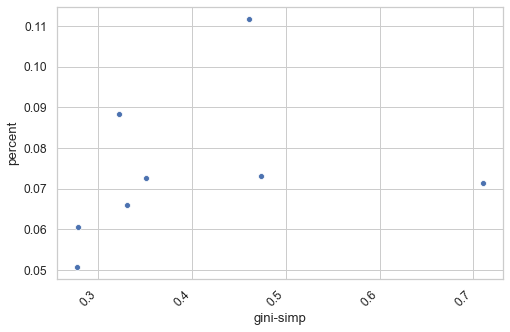

In [40]:
#Plots using Seaborn
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

bplot = sns.scatterplot(y='percent', x='gini-simp', data=dfAocSocio)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bplot.lines, color='k')


#rotate labels
for item in bplot.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right') #This sets horizontal alignment

In [41]:
#Spearmans Correlation for all variables in the table
dfAocSocio.corr(method='spearman')

,index,authorOfColor,count,total,percent,expectedAoc,avg-median-income,pop,numlfls,simpsons,gini-simp
index,1.000000,NaN,0.650814,0.642857,0.095238,0.642857,0.166667,0.571429,0.778457,0.523810,-0.523810
authorOfColor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
count,0.650814,NaN,1.000000,0.951190,0.525657,0.951190,-0.450564,0.550689,0.805813,0.025031,-0.025031
total,0.642857,NaN,0.951190,1.000000,0.285714,1.000000,-0.428571,0.404762,0.742528,0.142857,-0.142857
percent,0.095238,NaN,0.525657,0.285714,1.000000,0.285714,-0.261905,0.309524,0.311383,-0.547619,0.547619
expectedAoc,0.642857,NaN,0.951190,1.000000,0.285714,1.000000,-0.428571,0.404762,0.742528,0.142857,-0.142857
avg-median-income,0.166667,NaN,-0.450564,-0.428571,-0.261905,-0.428571,1.000000,-0.214286,-0.155691,0.571429,-0.571429
pop,0.571429,NaN,0.550689,0.404762,0.309524,0.404762,-0.214286,1.000000,0.838338,0.047619,-0.047619
numlfls,0.778457,NaN,0.805813,0.742528,0.311383,0.742528,-0.155691,0.838338,1.000000,0.191620,-0.191620
simpsons,0.523810,NaN,0.025031,0.142857,-0.547619,0.142857,0.571429,0.047619,0.191620,1.000000,-1.000000


In [42]:
#Use SciPy

import scipy
from scipy import stats

#The %.3f' sets the number of decimal places
coef, p = stats.spearmanr(dfAocSocio['gini-simp'],dfAocSocio['percent'])
print('Spearmans correlation coefficient: %.3f' % coef,' p-value: %.3f' % p)

Spearmans correlation coefficient: 0.548  p-value: 0.160


In [43]:
#The %.3f' sets the number of decimal places
coef, p = stats.spearmanr(dfAocSocio['avg-median-income'],dfAocSocio['percent'])
print('Spearmans correlation coefficient: %.3f' % coef,' p-value: %.3f' % p)

Spearmans correlation coefficient: -0.262  p-value: 0.531


## Create dataset with LFL volumes and owner intentions.
Ultimate Dataframe = bksctstat
Set up a seperate csv with lfl volume and house price. Make sure all numerical columns are number format. Year is okay as int

In [5]:
#Only do this if you are running from the beginning
dfstats = pd.read_csv('lfl-stats.csv')

In [7]:
dfstats['vol'] = (dfstats['width']*dfstats['length']*dfstats['height']/1728) #add a vol column with cubic feet units
dfstats = dfstats[np.isfinite(dfstats['vol'])] #Keep rows that have vol
dfstats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 0 to 41
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   collection  42 non-null     object 
 1   width       42 non-null     float64
 2   length      42 non-null     float64
 3   height      42 non-null     int64  
 4   volMeters   42 non-null     float64
 5   adjPrice    38 non-null     float64
 6   specific    42 non-null     object 
 7   current     42 non-null     object 
 8   variety     42 non-null     object 
 9   kids        42 non-null     object 
 10  religion    42 non-null     object 
 11  porn        42 non-null     object 
 12  vol         42 non-null     float64
dtypes: float64(5), int64(1), object(7)
memory usage: 4.6+ KB


In [8]:
#Groups count by collection
bksct = bks.groupby(['neighborhood','collection'])['count'].sum().reset_index()
bksct.head()

,neighborhood,collection,count
0,Central District,CentralDistrict1,4
1,Central District,CentralDistrict2,16
2,Central District,CentralDistrict3,30
3,Central District,CentralDistrict4,26
4,Central District,CentralDistrict5,7


### Books per Volume

In [9]:
#Create a new dataframe of book counts and lfl stats. Inner join is intersection so removes rows with no partner in other dataframe
bksctstat = pd.merge(dfstats, bksct, on='collection', how='inner')

In [7]:
bksctstat.head()
# The vol column is cubic feet

,collection,width,length,height,volMeters,adjPrice,specific,current,variety,kids,religion,porn,vol,neighborhood,count
0,CentralDistrict1,0.0,0.0,0,0.000000,0.0000,n,n,n,n,n,n,0.000000,Central District,4
1,CentralDistrict2,22.0,11.0,12,0.047588,536554.0424,n,n,n,n,n,n,1.680556,Central District,16
2,CentralDistrict3,23.0,11.0,14,0.058043,124155.9225,n,n,n,n,n,n,2.049769,Central District,30
3,CentralDistrict4,16.0,13.5,21,0.074332,437730.5987,n,n,n,n,y,n,2.625000,Central District,26
4,CentralDistrict5,13.0,14.5,12,0.037067,827225.2702,n,n,y,y,n,n,1.309028,Central District,7


In [10]:
bksctstat['bkPerVol'] = bksctstat['count']/bksctstat['vol']
bksctstat.head(5)

,collection,width,length,height,volMeters,adjPrice,specific,current,variety,kids,religion,porn,vol,neighborhood,count,bkPerVol
0,CentralDistrict1,0.0,0.0,0,0.000000,0.0000,n,n,n,n,n,n,0.000000,Central District,4,inf
1,CentralDistrict2,22.0,11.0,12,0.047588,536554.0424,n,n,n,n,n,n,1.680556,Central District,16,9.520661
2,CentralDistrict3,23.0,11.0,14,0.058043,124155.9225,n,n,n,n,n,n,2.049769,Central District,30,14.635799
3,CentralDistrict4,16.0,13.5,21,0.074332,437730.5987,n,n,n,n,y,n,2.625000,Central District,26,9.904762
4,CentralDistrict5,13.0,14.5,12,0.037067,827225.2702,n,n,y,y,n,n,1.309028,Central District,7,5.347480


In [9]:
totalbooks=bksctstat['count'].sum()
totalvol = bksctstat['vol'].sum()
bkdensity = totalbooks/totalvol
print(bkdensity)

7.419751759854206


In [16]:
#There is one LFL with no volume so it's density is 'inf'. Set that to null
bksctstat = bksctstat.replace(np.inf, np.nan)

In [17]:
#Look at range
print("Range books per cubic foot",bksctstat['bkPerVol'].min()," - ",bksctstat['bkPerVol'].max())

Range books per cubic foot 3.1973684210526314  -  22.2


In [10]:
bksctstat['medianVol'] = bksctstat.groupby('neighborhood')['bkPerVol'].transform('median')
mediansVol = bksctstat[['neighborhood','medianVol']].copy()
mediansVol.drop_duplicates(inplace=True)
mediansVol

,neighborhood,medianVol
0,Central District,9.712712
6,Columbia City,7.233909
11,Laurelhurst,7.132591
17,Montlake,11.760000
21,Northgate,10.633846
26,Phinney-Greenwood,9.376534
31,Queen Anne,9.047966
36,Ravenna,9.926579


[Text(0, 0.5, 'Books per Cubic Foot'),
 Text(0.5, 0, 'Seattle Little Free Libraries')]

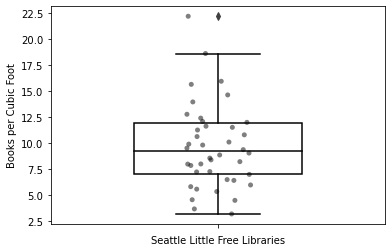

In [12]:
#Plots using Seaborn
bksctstatplot = sns.boxplot(y='bkPerVol', data=bksctstat,
                 width=0.5)
#                palette="colorblind")

#Remove default colors 
plt.setp(bksctstatplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bksctstatplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bksctstatplot =sns.stripplot(y='bkPerVol', data=bksctstat, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

bksctstatplot.set(xlabel='Seattle Little Free Libraries', ylabel='Books per Cubic Foot')

In [13]:
#Set up the dataframe to plot median book per volume by neighborhood

#Groups count by Neighborhood, calculate median
bksctstat['median'] = bksctstat.groupby('neighborhood')['bkPerVol'].transform('median')
bksctstat = bksctstat.sort_values(by=['median'], ascending=True).reset_index()
bksctstat.head(1)

,index,collection,width,length,height,volMeters,adjPrice,specific,current,variety,kids,religion,porn,vol,neighborhood,count,bkPerVol,medianVol,median
0,15,Laurelhurst5,15.0,15.0,15,0.055306,722576.8014,n,n,n,n,n,y,1.953125,Laurelhurst,22,11.264,7.132591,7.132591


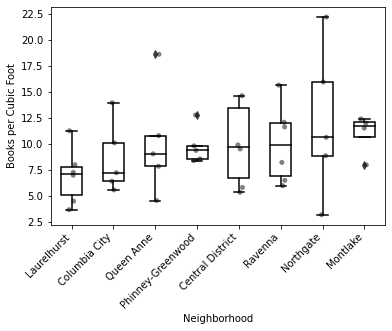

In [14]:
#Plots using Seaborn


bksctstatplot = sns.boxplot(y='bkPerVol', x='neighborhood', data=bksctstat,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bksctstatplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bksctstatplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bksctstatplot=sns.stripplot(y='bkPerVol', x='neighborhood', data=bksctstat, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

bksctstatplot.set(xlabel='Neighborhood', ylabel='Books per Cubic Foot')

#rotate labels
for item in bksctstatplot.get_xticklabels():
    item.set_rotation(45)
    item.set_ha('right')

In [15]:
#Save the file if you need it
bksctstat.to_csv('bkstats.csv', mode = 'w', index=False)

### Checking Preference

#### Checking People's Desires vs the Content - Children

In [37]:
#Create a new dataframe of children's books and lfl stats. Inner join is intersection so removes rows with no partner in other dataframe
bkspref = bks.groupby(['neighborhood', 'collection','age'])['count'].sum().reset_index()
bkschildren = bkspref.loc[bkspref['age']=="Childrens"]
bksstatchil = pd.merge(bksctstat, bkschildren, on='collection', how='inner')
bksstatchil.rename(columns = {'count_x':'total_count'}, inplace = True)
bksstatchil.rename(columns = {'count_y':'chil_count'}, inplace = True)
bksstatchil.rename(columns = {'neighborhood_y':'neighborhood'}, inplace = True)

bksstatchil.head()

,index,collection,width,length,height,volMeters,housePrice,address,priceLastSold,yearLastSold,...,porn,vol,neighborhood_x,total_count,bkPerVol,medianVol,median,neighborhood,age,chil_count
0,15,Laurelhurst5,15.0,15.0,15,0.055306,1497532,6116 65th Ave NE,522500.0,2003.0,...,y,1.953125,Laurelhurst,22,11.264000,7.132591,7.132591,Laurelhurst,Childrens,8
1,16,Laurelhurst6,16.0,12.0,14,0.044048,2298775,3916 NE Surber Dr.,1250000.0,2003.0,...,n,1.555556,Laurelhurst,7,4.500000,7.132591,7.132591,Laurelhurst,Childrens,1
2,14,Laurelhurst4,19.0,13.0,15,0.060714,1922694,6522 50th Ave NE,189070.0,1998.0,...,n,2.144097,Laurelhurst,15,6.995951,7.132591,7.132591,Laurelhurst,Childrens,1
3,13,Laurelhurst3,18.0,12.0,19,0.067252,1746975,6500 55th Ave NE,984000.0,2008.0,...,y,2.375000,Laurelhurst,19,8.000000,7.132591,7.132591,Laurelhurst,Childrens,6
4,12,Laurelhurst2,22.0,13.0,23,0.107794,1446525,4742 48th Ave NE,685000.0,2004.0,...,n,3.806713,Laurelhurst,14,3.677714,7.132591,7.132591,Laurelhurst,Childrens,2


In [38]:
#Calculate Percent
bksstatchil['percent'] = bksstatchil['chil_count']/bksstatchil['total_count']
bksstatchil[bksstatchil['kids']=='y']

,index,collection,width,length,height,volMeters,housePrice,address,priceLastSold,yearLastSold,...,vol,neighborhood_x,total_count,bkPerVol,medianVol,median,neighborhood,age,chil_count,percent
5,11,Laurelhurst1,16.0,13.0,16,0.054536,958935,4709 46th Ave NE,188000.0,1997.0,...,1.925926,Laurelhurst,14,7.269231,7.132591,7.132591,Laurelhurst,Childrens,2,0.142857
20,36,Ravenna1,16.5,11.0,22,0.065433,1002463,1211 NE 70th St,610000.0,2006.0,...,2.310764,Ravenna,19,8.222389,9.926579,9.926579,Ravenna,Childrens,7,0.368421
21,38,Ravenna3,17.0,17.0,21,0.099453,1246533,6211 Ravenna Ave NE,885000.0,2014.0,...,3.512153,Ravenna,21,5.979239,9.926579,9.926579,Ravenna,Childrens,4,0.190476
27,21,Northgate1,15.0,13.0,15,0.047932,705663,9000 5th Ave NE,NaN,NaN,...,1.692708,Northgate,27,15.950769,10.633846,10.633846,Northgate,Childrens,10,0.370370
29,19,Montlake5,15.0,13.0,15,0.047932,1090502,2505 20th Ave E,517000.0,2003.0,...,1.692708,Montlake,21,12.406154,11.760000,11.760000,Montlake,Childrens,2,0.095238


In [39]:
#Mean percent by whether they do not want religios books or na.  Need to compare to total mean.  Will need to create new dataframe.
bksstatchilcomp = bksstatchil.groupby(['kids'])['percent'].mean().reset_index()
bksstatchilcomp.head()

,kids,percent
0,n,0.245942
1,y,0.233473


In [40]:
#Get percents with zero values

bksagestat = pd.merge(bksctstat, bkspref, on='collection', how='inner')
#Calculate Percent
bksagestat['percent'] = bksagestat['count_y']/bksagestat['count_x']
#Get only childrens- should be one line for every collection with childrens material
bksagestatchil = bksagestat.loc[bksagestat['age']=="Childrens"]
#Get only the collection and percent columns
bksagestatchil = bksagestatchil[['collection','kids','percent']]
#Create dataframe of just collections
collections = bksctstat[['collection']]
#Merge to add the collections with no religious material and then convert NaNs to zero
percentschil = pd.merge(collections, bksagestatchil, on='collection', how='outer')
percentschil.fillna(0, inplace = True)

In [41]:
percentschil.head()

,collection,kids,percent
0,Laurelhurst5,n,0.363636
1,Laurelhurst6,n,0.142857
2,Laurelhurst4,n,0.066667
3,Laurelhurst3,n,0.315789
4,Laurelhurst2,n,0.142857


In [42]:
#For overall percent of children's books
#Get percents for each category
#Group by category
bksagepercent = bks.groupby(['age'])['count'].sum().reset_index()
#Get total
bkscatTotal = bks['count'].sum()
#create a percent column
bksagepercent['percent'] = bksagepercent['count']/bkscatTotal
#Sort by the percent
bksagepercent.sort_values(by='percent', ascending=False, inplace=True)
bksagepercent.head(15)

,age,count,percent
0,Adult,730,0.719921
1,Childrens,244,0.240631
2,Young Adult,40,0.039448


In [43]:
#Average percent children's material when kids material was present
print(bksagestatchil['percent'].mean())

0.2439308752879256


In [44]:
#Average percent childrens books in lfls incl zeros
percentschil['percent'].mean()

0.18004421747442131

In [45]:
#t-test

from scipy.stats import ttest_ind

cat1 = percentschil[percentschil['kids']=='y']
cat2 = percentschil[percentschil['kids']=='n']

ttest_ind(cat1['percent'], cat2['percent'])

Ttest_indResult(statistic=-0.19237968483306994, pvalue=0.8487856639414106)

In [135]:
#These are the same numbers as the groupby calculation above.
print(cat1['percent'].mean())
print(cat2['percent'].mean())

0.23347257031467555
0.2459420877827814


#### Checking People's Desires vs the Content - Religion
This is tough because most who say they don't want religious texts, don't have any so there are a lot of zeros.  Those get dropped in the inner join.
Best thing to do would be just report religion as exists or not.

In [46]:
#Create a new dataframe of religion books and lfl stats. Inner join is intersection so removes rows with no partner in other dataframe
bkscategory = bks.groupby(['neighborhood', 'collection','category1'])['count'].sum().reset_index()
bksrel = bkscategory.loc[bkscategory['category1']=="Religion"]
bksstatrel = pd.merge(bksctstat, bksrel, on='collection', how='inner')
bksstatrel.rename(columns = {'count_x':'total_count'}, inplace = True)
bksstatrel.rename(columns = {'count_y':'rel_count'}, inplace = True)
bksstatrel.rename(columns = {'neighborhood_y':'neighborhood'}, inplace = True)
#bksstatrel=bksstatchil.drop('neighborhood_x',1)
bksstatrel.head()

,index,collection,width,length,height,volMeters,housePrice,address,priceLastSold,yearLastSold,...,porn,vol,neighborhood_x,total_count,bkPerVol,medianVol,median,neighborhood,category1,rel_count
0,15,Laurelhurst5,15.0,15.00,15,0.055306,1497532,6116 65th Ave NE,522500.0,2003.0,...,y,1.953125,Laurelhurst,22,11.264000,7.132591,7.132591,Laurelhurst,Religion,1
1,16,Laurelhurst6,16.0,12.00,14,0.044048,2298775,3916 NE Surber Dr.,1250000.0,2003.0,...,n,1.555556,Laurelhurst,7,4.500000,7.132591,7.132591,Laurelhurst,Religion,1
2,8,ColumbiaCity3,21.0,12.00,19,0.078461,698514,3080 S Andover St.,117500.0,2003.0,...,n,2.770833,Columbia City,28,10.105263,7.233909,7.233909,Columbia City,Religion,1
3,6,ColumbiaCity1,15.5,10.75,21,0.057340,620272,5107 46th Ave S,157000.0,1999.0,...,n,2.024957,Columbia City,13,6.419891,7.233909,7.233909,Columbia City,Religion,1
4,35,QueenAnne5,13.5,11.00,15,0.036502,1180137,220 W Howe St.,105000.0,1985.0,...,y,1.289062,Queen Anne,24,18.618182,9.047966,9.047966,Queen Anne,Religion,1


In [47]:
#Calculate Percent
bksstatrel['percent'] = bksstatrel['rel_count']/bksstatrel['total_count']
bksstatrel[bksstatrel['religion']=='y']

,index,collection,width,length,height,volMeters,housePrice,address,priceLastSold,yearLastSold,...,vol,neighborhood_x,total_count,bkPerVol,medianVol,median,neighborhood,category1,rel_count,percent
8,29,Phinney-Green4,22.0,15.0,25,0.135193,822764,9716 Phinney Ave N.,315000.0,2002.0,...,4.774306,Phinney-Greenwood,61,12.776727,9.376534,9.376534,Phinney-Greenwood,Religion,2,0.032787
10,3,CentralDistrict4,16.0,13.5,21,0.074332,"764,635",3001 E. Harrison St.,325000.0,2004.0,...,2.625000,Central District,26,9.904762,9.712712,9.712712,Central District,Religion,3,0.115385
15,22,Northgate2,12.0,12.0,20,0.047195,843520,530 NE 100th St.,219950.0,1999.0,...,1.666667,Northgate,37,22.200000,10.633846,10.633846,Northgate,Religion,4,0.108108


[Text(0, 0.5, 'Percent religious books in LFL'),
 Text(0.5, 0, 'Steward reports removing religious books')]

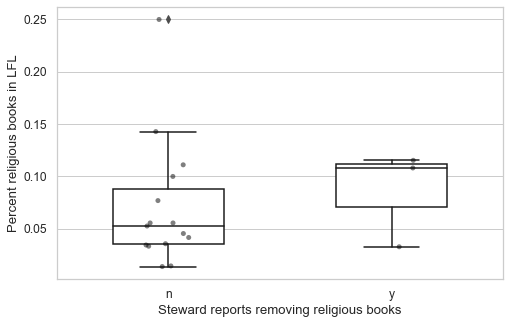

In [48]:
#Plots using Seaborn


bksstatrelplot = sns.boxplot(y='percent', x='religion', data=bksstatrel,
                 width=0.5)
#                 palette="colorblind")

#Remove default colors 
plt.setp(bksstatrelplot.artists, edgecolor = 'k', facecolor='w')
plt.setp(bksstatrelplot.lines, color='k')

# add stripplot to boxplot with Seaborn
bksstatrelplot=sns.stripplot(y='percent', x='religion', data=bksstatrel, 
                   jitter=True, 
                   marker='o', 
                   alpha=0.5,
                   color='black')

bksstatrelplot.set(xlabel='Steward reports removing religious books', ylabel='Percent religious books in LFL')


In [139]:
bkscatstat = pd.merge(bksctstat, bkscategory, on='collection', how='inner')
#Calculate Percent
bkscatstat['percent'] = bkscatstat['count_y']/bkscatstat['count_x']
#Get only religion- should be one line for every collection with religious material
bkscatstatrel = bkscatstat.loc[bkscatstat['category1']=="Religion"]
#Get only the collection and percent columns
bkscatstatrel = bkscatstatrel[['collection','percent']]
#Create dataframe of just collections
collections = bksctstat[['collection']]
#Merge to add the collections with no religious material and then convert NaNs to zero
percentsrel = pd.merge(collections, bkscatstatrel, on='collection', how='outer')
percentsrel.fillna(0, inplace = True)

In [151]:
#For overall percent religious material
#Get percents for each category
#Group by category
bksoverallpercent = bks.groupby(['category1'])['count'].sum().reset_index()
#Get total
bkscatTotal = bks['count'].sum()
#create a percent column
bksoverallpercent['percent'] = bksoverallpercent['count']/bkscatTotal
#Sort by the percent
bksoverallpercent.sort_values(by='percent', ascending=False, inplace=True)
bksoverallpercent.head(15)


,category1,count,percent
16,Null,238,0.234714
15,Novel,184,0.181460
13,Mystery,89,0.087771
25,Thriller/Suspense,68,0.067061
23,Self Help/Health,68,0.067061
21,SciFi/Fantasy,56,0.055227
3,Biography/Autobiography/Memoir,38,0.037475
6,Cookery,36,0.035503
8,Cultural Studies,29,0.028600
11,History,28,0.027613


In [140]:
#Average percent religious books in lfls incl zeros
percentsrel['percent'].mean()

0.03142730623785795

In [141]:
#Percent religious material when religious material was present
print(bksstatrel['percent'].mean())

0.07333038122166854


In [142]:
#t-test

from scipy.stats import ttest_ind

cat1 = bksstatrel[bksstatrel['religion']=='y']
cat2 = bksstatrel[bksstatrel['religion']=='n']

ttest_ind(cat1['percent'], cat2['percent'])

Ttest_indResult(statistic=0.38570192706777323, pvalue=0.7047974167216733)

# Bray Curtis Dissimilarity for Cluster Analysis
### Prepare dataframe for Bray Curtis dissimilarity
This sets up a dataframe that is formatted for a more efficient analysis in R. Could not figure out how to do cluster analysis with Python.

In [20]:
#Get percents of category1 by LFL. This is to compare what stewards say to what is in their library
bkscatlflct = bks

#Replace 'Null' with 'Childrens'
bkscatlflct['category1'] = np.where(bkscatlflct['age'] =='Childrens', 'Childrens', bkscatlflct['category1'])

bkscatlflct = bkscatlflct.groupby(['neighborhood','collection', 'category1'])['count'].sum().reset_index()

bkscatlflct = bkscatlflct.rename(columns={'collection': 'lflname'}) #changing name because this is also an index?



In [21]:
#Change the collection column to lflname in the dataframe with volume
bksctstatbc = bksctstat.rename(columns={'collection': 'lflname'})
bksctstatbc = bksctstatbc[['lflname','volMeters']]

#Merge the dataframes
bkscatlflctvol = pd.merge(bkscatlflct, bksctstatbc, on='lflname', how='inner')

#Remove the LFLs with no volume measurement
bkscatlflctvol = bkscatlflctvol[bkscatlflctvol['volMeters'] > 0]

#Calculate book per vol
bkscatlflctvol['density'] = bkscatlflctvol['count']/bkscatlflctvol['volMeters']

In [28]:
#Create dataframe to add in neighborhood column later
hoodscol = bks[['neighborhood', 'collection']].reset_index() #messy but works
hoodscol = hoodscol.rename(columns={'collection': 'lflname'})
hoodscol = hoodscol.drop(columns=['index'])
hoodscol = hoodscol.drop_duplicates()

In [31]:
#Set up the final file

#Unstack the opposite way for use in R
bkscatlflctvolwide = bkscatlflctvol[['lflname','category1','density']]
bkscatlflctvolwide = bkscatlflctvolwide.pivot(index='lflname',columns="category1", values='density')
bkscatlflctvolwide = bkscatlflctvolwide.fillna(0)

#merge to get the neighborhoods as a column
bkscatlflctvolwide = pd.merge(hoodscol, bkscatlflctvolwide, on='lflname', how='inner')

In [32]:
bkscatlflctvolwide.head()

,neighborhood,lflname,Anthology/Essays/Short stories,Art,Biography/Autobiography/Memoir,Business/Technology,Childrens,Classics,Cookery,Crafts,...,Poetry,Reference,Religion,Romance,SciFi/Fantasy,Science,Self Help/Health,Sports,Thriller/Suspense,Travel
0,Central District,CentralDistrict2,63.041103,0.000000,0.000000,21.013701,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.013701,0.000000,42.027402,0.000000
1,Central District,CentralDistrict5,26.978175,0.000000,53.956349,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.978175,0.000000,0.000000,0.000000
2,Columbia City,ColumbiaCity3,25.490371,0.000000,0.000000,0.000000,101.961484,25.490371,12.745186,0.000000,...,0.000000,0.000000,12.745186,0.000000,12.745186,0.000000,0.000000,0.000000,12.745186,0.000000
3,Phinney-Greenwood,Phinney-Green4,14.793665,0.000000,0.000000,0.000000,177.523984,0.000000,0.000000,0.000000,...,7.396833,0.000000,0.000000,14.793665,22.190498,0.000000,7.396833,0.000000,44.380996,0.000000
4,Northgate,Northgate3,0.784126,0.784126,3.920631,0.000000,47.831695,0.000000,0.000000,7.057135,...,0.000000,2.352378,1.568252,1.568252,6.273009,1.568252,5.488883,5.488883,3.920631,0.784126


In [16]:
#Save csv file for use in R
bkscatlflctvolwide.to_csv('cluster/cat-density-collection.csv', mode = 'w', index=False)

## Categories by Neighborhood
The resulting pie charts show the top 75% of books


In [32]:
#Look at general categories
bkscatgen = bks

#Replace 'Null' with 'Childrens'
bkscatgen['category1'] = np.where(bkscatgen['age'] =='Childrens', 'Childrens', bkscatgen['category1'])

#Group by category
bkscatgen = bks.groupby(['category1'])['count'].sum().reset_index()

#Get total
bkscatTotal = bkscatgen['count'].sum()
#create a percent column
bkscatgen['percent'] = bkscatgen['count']/bkscatTotal
#Sort by the percent
bkscatgen.sort_values(by='percent', ascending=False, inplace=True)
bkscatgen.head(15)


,category1,count,percent
4,Childrens,244,0.240631
15,Novel,184,0.181460
13,Mystery,89,0.087771
24,Thriller/Suspense,68,0.067061
22,Self Help/Health,68,0.067061
20,SciFi/Fantasy,56,0.055227
2,Biography/Autobiography/Memoir,39,0.038462
6,Cookery,36,0.035503
8,Cultural Studies,29,0.028600
11,History,28,0.027613


## Chart top 5 categories

In [37]:
#Get percents of category1 by neighborhood
bkscat = bks.groupby(['neighborhood', 'category1Code'])['count'].sum().reset_index()
#Replace 'Null' with 'Childrens'
bkscat.loc[bkscat.category1Code == 'NU', 'category1Code'] = 'CH'
bkscat.loc[bkscat.category1Code == 'MYS', 'category1Code'] = 'M'
bkscat.loc[bkscat.category1Code == 'SCIFI', 'category1Code'] = 'SF'
#Create a total column grouped by neighborhood
bkscat['total'] = bkscat.groupby('neighborhood')['count'].transform('sum')
#create a percent column
bkscat['percent'] = bkscat['count']/bkscat['total']
#Sort by the percent
bkscat = bkscat.groupby('neighborhood').apply(pd.DataFrame.sort_values, 'percent', ascending=False)
#Neighborhood column at this point is both the grouping column and a data column, so delete the data one.
#bkscat = bkscat.drop('neighborhood', 1)
bkscat = bkscat.rename(columns={'neighborhood': 'hoodname'})
#Create a cumulative count column by neighborhood
bkscat['cumulct'] = bkscat.groupby(['neighborhood']).cumcount()+1
#Create a new column with the categories not in top 5 categories or over in cumulper marked as 'other'
bkscat['newcat'] = np.where(bkscat['cumulct'] < 6, bkscat['category1Code'], 'Other')
bkscat.head(20)

hoodname category1Code  count  total   percent  \
neighborhood                                                                  
Central District 9   Central District            CH     20     91  0.219780   
                 8   Central District           NOV     15     91  0.164835   
                 15  Central District            TH      9     91  0.098901   
                 2   Central District           BIO      7     91  0.076923   
                 7   Central District             M      7     91  0.076923   
                 10  Central District             R      6     91  0.065934   
                 6   Central District             H      5     91  0.054945   
                 14  Central District            SH      5     91  0.054945   
                 0   Central District            AN      4     91  0.043956   
                 5   Central District            CS      4     91  0.043956   
                 13  Central District            SF      3     91  0.032967   
                 11  Central District            RO      2     91  0.021978   
                 1   Central District           ART      1     91  0.010989   
                 3   Central District            BU      1     91  0.010989   
                 4   Central District            CR      1     91  0.010989   
                 12  Central District             S      1     91  0.010989   
Columbia City    27     Columbia City           NOV     16     86  0.186047   
                 28     Columbia City            CH     15     86  0.174419   
                 18     Columbia City           BIO      6     86  0.069767   
                 33     Columbia City            SH      6     86  0.069767   

                     cumulct newcat  
neighborhood                         
Central District 9         1     CH  
                 8         2    NOV  
                 15        3     TH  
                 2         4    BIO  
                 7         5      M  
                 10        6  Other  
                 6         7  Other  
                 14        8  Other  
                 0         9  Other  
                 5        10  Other  
                 13       11  Other  
                 11       12  Other  
                 1        13  Other  
                 3        14  Other  
                 4        15  Other  
                 12       16  Other  
Columbia City    27        1    NOV  
                 28        2     CH  
                 18        3    BIO  
                 33        4     SH

In [38]:
#Sum the counts by newcat
bkscatsumall = bkscat.groupby(['neighborhood','newcat'])['count'].sum().reset_index()
bkscatsumall.head(10)

,neighborhood,newcat,count
0,Central District,BIO,7
1,Central District,CH,20
2,Central District,M,7
3,Central District,NOV,15
4,Central District,Other,33
5,Central District,TH,9
6,Columbia City,BIO,6
7,Columbia City,CH,15
8,Columbia City,NOV,16
9,Columbia City,Other,37


### Plot the Categories

In [39]:
catnames = bkscatsumall['newcat'].unique() #Create list of neighborhood names 
#These set up the color scheme for the pie charts
cmap = plt.cm.gist_earth #tab20b (0.1, 0.9)
colors = cmap(np.linspace(0.1, 0.85, len(catnames)))   #0.85 because Ravenna has white slice otherwise
labels = catnames

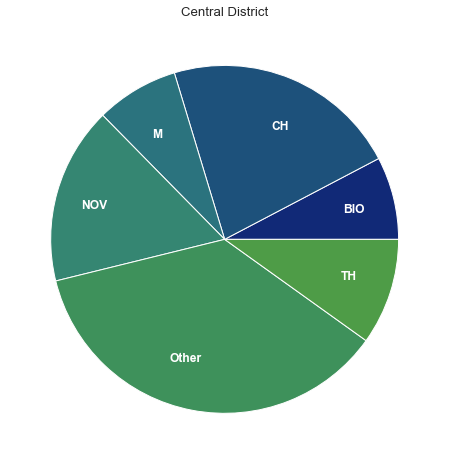

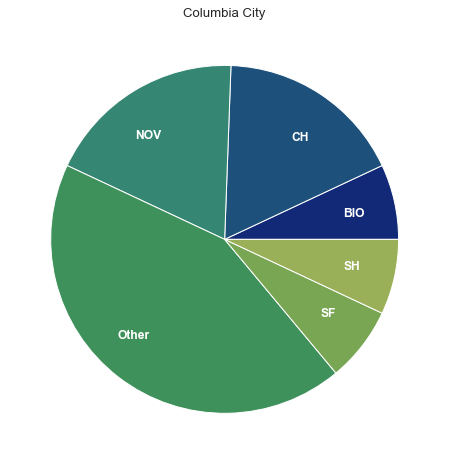

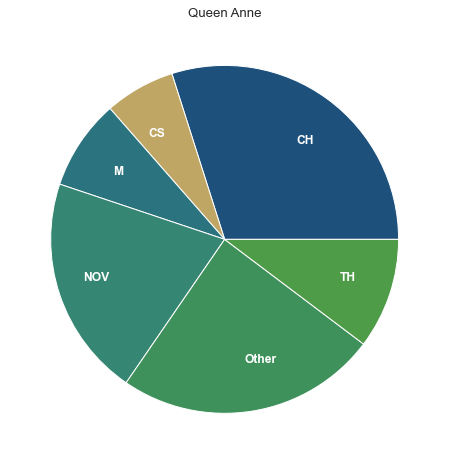

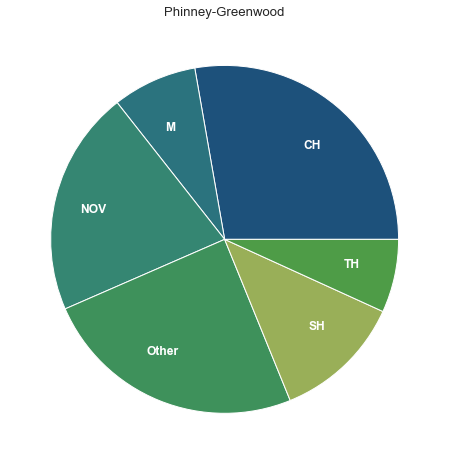

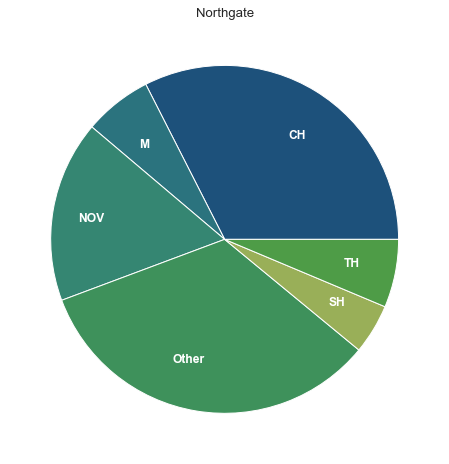

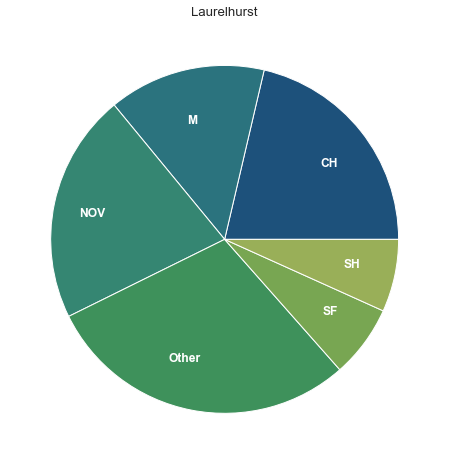

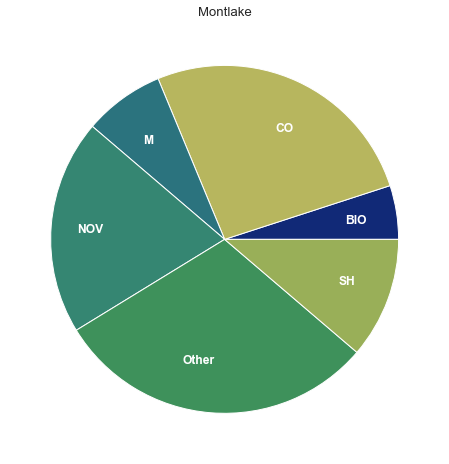

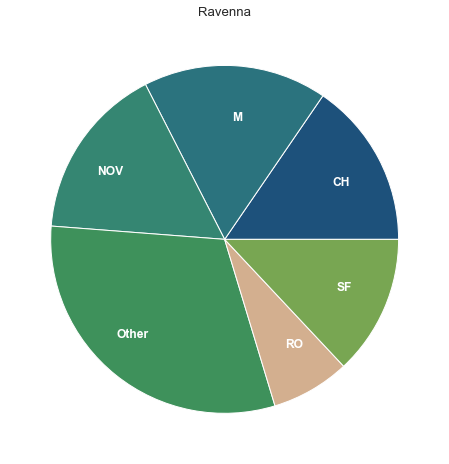

In [41]:
#There's got to be a way to put this all in a loop, but the function mypie assigns colors
#to the slices based on a dictionary so all colors by category are the same.

#https://stackoverflow.com/questions/35206282/assign-specific-colours-to-data-in-matplotlib-pie-chart
#https://matplotlib.org/stable/tutorials/colors/colormaps.html

#This might be a simpler solution!: https://stackoverflow.com/questions/41787006/making-multiple-pie-charts-out-of-a-pandas-dataframe-one-for-each-row

hood='Central District'

def mypie(slices,labels,colors):

    colordict={}
    for l,c in zip(labels,colors):
        #print(l,c)
        colordict[l]=c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    pie_wedge_collection = ax.pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood]['newcat'], labeldistance=0.7, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

    titlestring = hood

    ax.set_title(titlestring)

    return fig,ax,pie_wedge_collection

slices = bkscatsumall[bkscatsumall['neighborhood']==hood]['count']
fig,ax,pie_wedge_collection = mypie(slices,labels,colors)
#Save figure 
plt.savefig('../figures/central.eps')

hood1='Columbia City'

def mypie(slices,labels,colors):

    colordict={}
    for l,c in zip(labels,colors):
        #print(l,c)
        colordict[l]=c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    pie_wedge_collection = ax.pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood1]['newcat'], labeldistance=0.7, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

    titlestring = hood1

    ax.set_title(titlestring)

    return fig,ax,pie_wedge_collection

slices = bkscatsumall[bkscatsumall['neighborhood']==hood1]['count']
fig,ax,pie_wedge_collection = mypie(slices,labels,colors)
#Save figure 
plt.savefig('../figures/columbia.eps')

hood2='Queen Anne'

def mypie(slices,labels,colors):

    colordict={}
    for l,c in zip(labels,colors):
        #print(l,c)
        colordict[l]=c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    pie_wedge_collection = ax.pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood2]['newcat'], labeldistance=0.7, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

    titlestring = hood2

    ax.set_title(titlestring)

    return fig,ax,pie_wedge_collection

slices = bkscatsumall[bkscatsumall['neighborhood']==hood2]['count']
fig,ax,pie_wedge_collection = mypie(slices,labels,colors)
#Save figure 
plt.savefig('../figures/queenanne.eps')

hood3='Phinney-Greenwood'

def mypie(slices,labels,colors):

    colordict={}
    for l,c in zip(labels,colors):
        #print(l,c)
        colordict[l]=c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    pie_wedge_collection = ax.pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood3]['newcat'], labeldistance=0.7, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

    titlestring = hood3

    ax.set_title(titlestring)

    return fig,ax,pie_wedge_collection

slices = bkscatsumall[bkscatsumall['neighborhood']==hood3]['count']
fig,ax,pie_wedge_collection = mypie(slices,labels,colors)
#Save figure 
plt.savefig('../figures/phinney.eps')

hood4='Northgate'

def mypie(slices,labels,colors):

    colordict={}
    for l,c in zip(labels,colors):
        #print(l,c)
        colordict[l]=c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    pie_wedge_collection = ax.pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood4]['newcat'], labeldistance=0.7, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

    titlestring = hood4

    ax.set_title(titlestring)

    return fig,ax,pie_wedge_collection

slices = bkscatsumall[bkscatsumall['neighborhood']==hood4]['count']
fig,ax,pie_wedge_collection = mypie(slices,labels,colors)
#Save figure 
plt.savefig('../figures/northgate.eps')

hood5='Laurelhurst'

def mypie(slices,labels,colors):

    colordict={}
    for l,c in zip(labels,colors):
        #print(l,c)
        colordict[l]=c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    pie_wedge_collection = ax.pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood5]['newcat'], labeldistance=0.7, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

    titlestring = hood5

    ax.set_title(titlestring)

    return fig,ax,pie_wedge_collection

slices = bkscatsumall[bkscatsumall['neighborhood']==hood5]['count']
fig,ax,pie_wedge_collection = mypie(slices,labels,colors)
#Save figure 
plt.savefig('../figures/laurelhurst.eps')

hood6='Montlake'

def mypie(slices,labels,colors):

    colordict={}
    for l,c in zip(labels,colors):
        #print(l,c)
        colordict[l]=c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    pie_wedge_collection = ax.pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood6]['newcat'], labeldistance=0.7, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

    titlestring = hood6

    ax.set_title(titlestring)

    return fig,ax,pie_wedge_collection

slices = bkscatsumall[bkscatsumall['neighborhood']==hood6]['count']
fig,ax,pie_wedge_collection = mypie(slices,labels,colors)
#Save figure 
plt.savefig('../figures/montlake.eps')

hood7='Ravenna'

def mypie(slices,labels,colors):

    colordict={}
    for l,c in zip(labels,colors):
        #print(l,c)
        colordict[l]=c

    fig = plt.figure()
    ax = fig.add_subplot(111)

    pie_wedge_collection = ax.pie(slices, labels=bkscatsumall[bkscatsumall['neighborhood']==hood7]['newcat'], labeldistance=0.7, textprops={'color':"w",'weight':"bold"})#, autopct=make_autopct(slices))

    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])

    titlestring = hood7

    ax.set_title(titlestring)

    return fig,ax,pie_wedge_collection

slices = bkscatsumall[bkscatsumall['neighborhood']==hood7]['count']
fig,ax,pie_wedge_collection = mypie(slices,labels,colors)
#Save figure 
plt.savefig('../figures/ravenna.eps')

plt.show()

## Language

In [78]:
bks.head()

,yrpub,count,neighborhood,collection,type,age,category1,category2,languages,originalLang
0,2018,1,Central District,CentralDistrict4,Fiction,Adult,Thriller/Suspense,Null,English,English
1,1991,1,Laurelhurst,Laurelhurst2,Fiction,Adult,Cultural Studies,Null,English,English
2,2019,1,Central District,CentralDistrict1,Nonfiction,Adult,Cultural Studies,Null,English,English
3,1992,1,Central District,CentralDistrict1,Fiction,Adult,Novel,Null,English,English
4,2007,1,Central District,CentralDistrict1,Fiction,Adult,Religion,Null,English,English


In [79]:
bks.originalLang.unique()

array(['English', nan, 'Akkadian', 'Latin', 'Swedish', 'Arabic', 'French',
       'Chinese', 'German', 'Spanish', 'Japanese', 'Thai', 'Undetermined'],
      dtype=object)

In [80]:
#Groups count by Neighborhood, collection, and type (fiction or non fiction), calculate percent
bkslang = bks.groupby(['languages'])['count'].sum().reset_index()
#bkslang['total'] = bksfiction.groupby('collection')['count'].transform('sum')
#bkslang['percent'] = bksfiction['count']/bksfiction['total']
bkslang

,languages,count
0,English,954
1,"English, Achinese",2
2,"English, French",2
3,"English, Italian",1
4,"English, Spanish",1
5,"English, Undetermined",2
6,French,2
7,German,1
8,"Hindi, English",1
9,Japanese,1
